In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(link, sep=';')

In [3]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### 1.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [4]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [5]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]
clfs = [RandomForestClassifier(n_estimators=100), BaggingClassifier(n_estimators=100), DecisionTreeClassifier()]

for clf in clfs:
    print(clf)
    %time cvs = cross_val_score(clf, X, y, scoring='accuracy', cv=3).mean()
    print(cvs, '\n')

RandomForestClassifier()
Wall time: 943 ms
0.557848655409631 

BaggingClassifier(n_estimators=100)
Wall time: 1.82 s
0.5616010006253909 

DecisionTreeClassifier()
Wall time: 31.3 ms
0.44903064415259536 



Результат по метрике accuracy у RandomForestClassifier почти такой-же как и у BaggingClassifier, но скорость обучения быстрее в ~2 раза.

### 2.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [6]:
def split_df(df, test_size=.3, size=1, seed=42):
    df_res = df.sample(int(df.shape[0]*size)).copy() if size != 1 else df.copy()
    X_res, y_res = df_res.iloc[:,:-1], df_res.iloc[:,-1]
    X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res, test_size=test_size, random_state=seed)
    return df_res, X_res, y_res, X_res_train, X_res_test, y_res_train, y_res_test

In [7]:
df, X, y, X_train, X_test, y_train, y_test = split_df(data)
print(df.shape, X.shape, X_train.shape, X_test.shape)

(1599, 12) (1599, 11) (1119, 11) (480, 11)


### 3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



In [8]:
from matplotlib import pyplot as plt

In [9]:
%%time
N = [10, 50, 100] + [n for n in range(200,5001,200)]
scores = []

for n in N:
    clf = RandomForestClassifier(n_estimators=int(n), n_jobs=-1)
    clf.fit(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    score_train = clf.score(X_train, y_train)
    scores.append({'n':int(n), 'score_test':score_test, 'score_train':score_train})

Wall time: 2min 33s


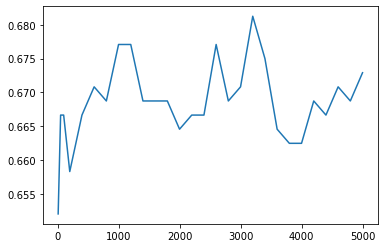

In [10]:
scores_df = pd.DataFrame(scores)

plt.plot(scores_df.n, scores_df.score_test)
#plt.plot(scores_df.n, scores_df.score_train)

### 4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
X, y = data.iloc[:,:-1], data.iloc[:,-1]
clfs = [{'name':'GradientBoostingClassifier', 'model':GradientBoostingClassifier()}, 
        {'name':'XGBClassifier', 'model':XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')}]

for clf in clfs:
    clf_name = clf['name']
    model = clf['model']
    print(clf_name)
    %time cvs = cross_val_score(model, X, y, scoring="accuracy", cv=5).mean()
    print(cvs, '\n')

GradientBoostingClassifier
Wall time: 8.04 s
0.5697315830721004 

XGBClassifier
Wall time: 1.99 s
0.5472335423197492 



### 5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'presort', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [16]:
XGBClassifier().get_params().keys()

dict_keys(['objective', 'use_label_encoder', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [17]:
models = [
    {
        'clf': GradientBoostingClassifier,
        'params': [{
            'criterion': ['friedman_mse', 'mae'],
            'learning_rate': [.1, .5, .9],
            'n_estimators': [10, 20, 30], 
            'max_depth': [2, 3, 4]
        }]
    }, {
        'clf': XGBClassifier,
        'params': [{
            'objective': ['multi:softprob'],
            'eval_metric': ['mlogloss', 'mae'],
            'learning_rate': [.1, .5, .9],
            'n_estimators': [10, 20, 30],  
            'max_depth': [2, 3, 4]
        }]
    }
]

cv_dfs = []

for model in models:
    clf_name = model['clf'].__name__
    clf = model['clf']
    params = model['params']
    %time search = GridSearchCV(clf(), param_grid=params, scoring='accuracy', cv=3, n_jobs=-1).fit(X, y)
    cv_df = pd.DataFrame(search.cv_results_)
    cv_df['clf_name'] = clf_name
    cv_dfs.append(cv_df)
    print(clf_name)
    print(search.best_params_)

Wall time: 1min 44s
GradientBoostingClassifier
{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}
Wall time: 7.33 s
XGBClassifier
{'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 20, 'objective': 'multi:softprob'}


In [18]:
cvs_df = pd.concat(cv_dfs).reset_index(drop=True)
best_models = cvs_df[
        (cvs_df.mean_fit_time == cvs_df.mean_fit_time.min()) |
        #(cvs_df.mean_score_time == cvs_df.mean_score_time.min()) | 
        (cvs_df.mean_test_score == cvs_df.mean_test_score.max())]
best_models = best_models[[
        'clf_name',
        'mean_test_score',
        'mean_fit_time',
        'mean_score_time',
        'param_criterion',
        'param_learning_rate',
        'param_max_depth',
        'param_n_estimators',
        'param_eval_metric'
]]
best_models

,clf_name,mean_test_score,mean_fit_time,mean_score_time,param_criterion,param_learning_rate,param_max_depth,param_n_estimators,param_eval_metric
61,XGBClassifier,0.585991,0.408848,0.000000,NaN,0.1,4,20,mlogloss
63,XGBClassifier,0.557849,0.096069,0.007382,NaN,0.5,2,10,mlogloss
88,XGBClassifier,0.585991,0.486933,0.007210,NaN,0.1,4,20,mae


### 6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [19]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [33]:
model = GradientBoostingClassifier
print(model.__name__, '\n')
      
%time cvs = cross_val_score(model(), X, y, scoring="accuracy", cv=3).mean()
print('cross_val_score - ', cvs, '\n')

GradientBoostingClassifier 

Wall time: 4.42 s
cross_val_score -  0.541588492808005 



In [34]:
model = XGBClassifier
print(model.__name__, '\n')
      
%time cvs = cross_val_score(model(objective='multi:softprob', eval_metric='mlogloss'), X, y, scoring="accuracy", cv=3).mean()
print('cross_val_score - ', cvs, '\n')

XGBClassifier 

Wall time: 1.21 s
cross_val_score -  0.5284552845528455 



In [35]:
model = LGBMClassifier
print(model.__name__, '\n')
      
%time cvs = cross_val_score(model(), X, y, scoring="accuracy", cv=3).mean()
print('cross_val_score - ', cvs, '\n')

LGBMClassifier 

Wall time: 1.07 s
cross_val_score -  0.5284552845528455 



In [36]:
model = CatBoostClassifier
print(model.__name__, '\n')
      
%time cvs = cross_val_score(model(verbose=False), X, y, scoring="accuracy", cv=3).mean()
print('cross_val_score - ', cvs, '\n')

CatBoostClassifier 

Wall time: 20.4 s
cross_val_score -  0.5328330206378987 



### 7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

In [24]:
LGBMClassifier().get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [25]:
#CatBoostClassifier(verbose=False).fit(X,y).get_all_params()

In [26]:
models = [
    {
        'clf': LGBMClassifier,
        'params': [{
            'objective': ['multi:softprob'],
            'eval_metric': ['mlogloss', 'mae'],
            'learning_rate': [.1, .5, .9],
            'n_estimators': [10, 20, 30],  
            'max_depth': [2, 3, 4]}]
    }, {
        'clf': CatBoostClassifier,
        'params': [{
            'loss_function': ['MultiClass'],
            'eval_metric': ['MultiClass'],
            'learning_rate': [.1, .5, .9],
            'n_estimators': [10, 20, 30],  
            'max_depth': [2, 3, 4],
            'verbose': [False]}]
    }
]

cv_dfs = []

for model in models:
    clf_name = model['clf'].__name__
    clf = model['clf']
    params = model['params']
    %time search = GridSearchCV(clf(), param_grid=params, scoring='accuracy', cv=3, n_jobs=-1).fit(X, y)
    cv_df = pd.DataFrame(search.cv_results_)
    cv_df['clf_name'] = clf_name
    cv_dfs.append(cv_df)
    print(clf_name)
    print(search.best_params_, '\n')

[LightGBM] [Warning] Unknown parameter: eval_metric
Wall time: 4.83 s
LGBMClassifier
{'eval_metric': 'mlogloss', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 20, 'objective': 'multi:softprob'} 

Wall time: 3.2 s
CatBoostClassifier
{'eval_metric': 'MultiClass', 'learning_rate': 0.1, 'loss_function': 'MultiClass', 'max_depth': 4, 'n_estimators': 30, 'verbose': False} 



In [27]:
cvs_df = pd.concat(cv_dfs).reset_index(drop=True)
best_models = cvs_df[
        (cvs_df.mean_fit_time == cvs_df.mean_fit_time.min()) |
        #(cvs_df.mean_score_time == cvs_df.mean_score_time.min()) | 
        (cvs_df.mean_test_score == cvs_df.mean_test_score.max())]
best_models = best_models[[
        'clf_name',
        'mean_test_score',
        'mean_fit_time',
        'mean_score_time',
        'param_learning_rate',
        'param_max_depth',
        'param_n_estimators',
        'param_eval_metric'
]]
best_models

,clf_name,mean_test_score,mean_fit_time,mean_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_eval_metric
36,LGBMClassifier,0.548468,0.052121,0.00672,0.5,2,10,mae
62,CatBoostClassifier,0.587867,0.294592,0.01089,0.1,4,30,MultiClass


### 8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [hyperopt](https://github.com/hyperopt/hyperopt) . Параметры для оптимизации:

оптимизируемый функционал

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [28]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from functools import partial
from sklearn.pipeline import Pipeline

In [29]:
models = [
    {'name':'xgbc', 'clf':XGBClassifier(), 'eval_metrics':['mlogloss', 'mae']}
]

def objective(params, pipe,  X_train, y_train):
    pipe.set_params(**params)
    score = cross_val_score(estimator=pipe, X=X_train, y=y_train, scoring='accuracy', cv=3, n_jobs=-1)
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

for model in models:
    name = model['name']
    clf = model['clf']
    eval_metrics = model['eval_metrics']
    pipe = Pipeline([(name, clf)])
    search_space = {
        name+'__eval_metric': hp.choice(label="eval_metric", options=eval_metrics),
        name+'__learning_rate' : hp.loguniform(label='learning_rate', low=np.log(0.04), high=np.log(0.5)),
        name+'__max_depth' :  hp.choice(label="max_depth", options=np.arange(2, 10, 1, dtype=int)),
        name+'__n_estimators' : hp.choice(label="n_estimators", options=np.arange(1, 100, 10, dtype=int))
    }
    trials = Trials()
    best = fmin( 
        fn=partial(objective, pipe=pipe, X_train=X, y_train=y),
        space=search_space,
        algo=tpe.suggest,
        max_evals=40,
        trials=trials,
        show_progressbar=True
    )
    print('name -', name)
    print('loss -', trials.best_trial['result']['loss'])
    for param_name in trials.best_trial['result']['params']:
        print(param_name.split('__')[1], '-', trials.best_trial['result']['params'][param_name])
    print('\n')

100%|███████████████████████████████████████████████| 40/40 [00:18<00:00,  2.20trial/s, best loss: -0.5803627267041901]
name - xgbc
loss - -0.5803627267041901
eval_metric - mlogloss
learning_rate - 0.1479200097500323
max_depth - 6
n_estimators - 11




### 9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [30]:
from sklearn.ensemble import StackingClassifier

In [31]:
estimators = [
    ('cbc', CatBoostClassifier()),
    ('lgbmc', LGBMClassifier()),
    ('rfc', GradientBoostingClassifier()),
    ('xgbc', XGBClassifier())
]
stacked = StackingClassifier(estimators=estimators)
%time score = cross_val_score(estimator=stacked, X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1).mean()
score

Wall time: 1min 32s


0.5666041275797373

### 10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [37]:
models = [
    {'name':'gbc', 'clf':GradientBoostingClassifier(), 
     'metrics':{'param_name':'criterion','param_vals':['friedman_mse', 'mae']}},
    {'name':'xgbc', 'clf':XGBClassifier(),
     'metrics':{'param_name':'eval_metric','param_vals':['mlogloss', 'mae']}},
    {'name':'lgbmc', 'clf':LGBMClassifier(objective='multi:softprob'),
     'metrics':{'param_name':'eval_metric','param_vals':['mlogloss', 'mae']}},
    {'name':'cbc', 'clf':CatBoostClassifier(loss_function='MultiClass'),
     'metrics':{'param_name':'eval_metric','param_vals':['MultiClass']}},
]

def objective(params, pipe,  X_train, y_train):
    pipe.set_params(**params)
    score = cross_val_score(estimator=pipe, X=X_train, y=y_train, scoring='accuracy', cv=3, n_jobs=-1)
    return {'loss': -score.mean(), 'params': params, 'status': STATUS_OK}

best_trials = {}

for model in models:
    name = model['name']
    clf = model['clf']
    param_name = model['metrics']['param_name']
    param_vals = model['metrics']['param_vals']
    pipe = Pipeline([(name, clf)])
    search_space = {
        name+'__'+param_name: hp.choice(label=param_name, options=param_vals),
        name+'__learning_rate' : hp.loguniform(label='learning_rate', low=np.log(0.04), high=np.log(0.5)),
        name+'__max_depth' :  hp.choice(label="max_depth", options=np.arange(2, 10, 1, dtype=int)),
        name+'__n_estimators' : hp.choice(label="n_estimators", options=np.arange(1, 100, 10, dtype=int))
    }
    trials = Trials()
    best = fmin( 
        fn=partial(objective, pipe=pipe, X_train=X, y_train=y),
        space=search_space,
        algo=tpe.suggest,
        max_evals=40,
        trials=trials,
        show_progressbar=True
    )
    best_trials[name] = trials.best_trial
    print('name -', name)
    print('loss -', trials.best_trial['result']['loss'])
    for param_name in trials.best_trial['result']['params']:
        print(param_name.split('__')[1], '-', trials.best_trial['result']['params'][param_name])
    print('\n')

100%|████████████████████████████████████████████████| 40/40 [05:45<00:00,  8.65s/trial, best loss: -0.575984990619137]
name - gbc
loss - -0.575984990619137
criterion - friedman_mse
learning_rate - 0.04371211482448806
max_depth - 2
n_estimators - 91


100%|███████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77trial/s, best loss: -0.5797373358348968]
name - xgbc
loss - -0.5797373358348968
eval_metric - mlogloss
learning_rate - 0.044117644495022944
max_depth - 5
n_estimators - 21


100%|███████████████████████████████████████████████| 40/40 [00:17<00:00,  2.24trial/s, best loss: -0.5766103814884302]
name - lgbmc
loss - -0.5766103814884302
eval_metric - mae
learning_rate - 0.09700525753870985
max_depth - 3
n_estimators - 11


100%|███████████████████████████████████████████████| 40/40 [00:41<00:00,  1.05s/trial, best loss: -0.5916197623514696]
name - cbc
loss - -0.5916197623514696
eval_metric - MultiClass
learning_rate - 0.08220908947481331
max_depth - 5
n_estimators -

In [38]:
clfs = {'gbc':GradientBoostingClassifier, 'xgbc':XGBClassifier, 'lgbmc':LGBMClassifier, 'cbc':CatBoostClassifier}
optimal_models = []
for name in best_trials:
    params = best_trials[name]['result']['params']
    renamed_params = {}
    for param_name in params:
        renamed_name = param_name.split('__')[1]
        renamed_params[renamed_name] = params[param_name]
    model = clfs[name]
    optimal_model = model(**renamed_params)
    optimal_models.append((name, optimal_model))

stacked = StackingClassifier(estimators=optimal_models)
%time score = cross_val_score(estimator=stacked, X=X, y=y, scoring='accuracy', cv=3, n_jobs=-1).mean()
score

Wall time: 11.9 s


0.5934959349593497

Стэкинг моделей с оптимальными параметрами, показывает более лучший результат по метрике и по времени обучения. Вывод- данный ансамблевый лучше применять на предподготовленных моделях с заранее подобранными оптимальными параметрами.